#                 Assessing the current Covid scenario for New York State

### Proposal:
    
A subset of Natural Disaster Management in the state of New York is the problem that is currently being addressed. Across New York State, we're looking into the consequences of Covid 19.

### Objective:

Our goal is to analyze the covid 19 data across the New York state and predict a scenario for the county with the greatest impact.We attempt to compare the present rate of New Positives and the number of Daily Tests Performed in the worst-affected county to the rate of Daily Vaccination and the rate of Daily Deaths.In addition, Time Series Analysis is used to forecast future trend on New Positives using it's historical data patterns,and suggest recommendations for what can be done.

### Data Being Used:

We require data on testing, fatalities, and immunization data county wise throughtout the New York state.

#### 1 Test Data:

To analyze the situation, we scrapped the testing data from https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Testing/xdss-u53e.

Beginning March 1, 2020, when the first case of COVID-19 was reported in the state, this page contains data on the number of COVID-19 infection tests performed on persons in New York State.


1 *Date:* Date of testing, death, and vaccinated 
<br>2 *County:* The county of residence. 
<br>3 *Total Number of tests Performed:* The number of tests of individuals performed on the test date in each county. This total      includes positives, negatives, and inconclusive results.
<br>4 *New Positives:* The number of new persons tested positive for COVID-19 infection on the test date in each county. 
<br>5 *Cummulative Number of Positives:* Runnuing total for the number of persons tested positive for COVID_19 in each county as of the test date.
<br>6 *Cummulative Number of Tests Performed:* Running total for the number of tests of individuals performed in each county as of the last update to the dataset. This total includes positives, negatives, and inconclusive results.


#### 2 Data on Fatalities:

We used the data of fatalities from https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Fatalities-by-Co/xymy-pny5

This page shows the total number of fatalities reported by healthcare facilities for patients with lab-confirmed COVID-19 disease, broken down by reporting date, patient county of residence, and patient fatalities by facility county.

1 *Deaths by county of Residence:* Based on the patient's county of residence, the number of patient fatalities in hospitals, nursing homes, and adult care institutions.

#### 3 Vaccination Data

We leverage the immunization data from https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Vaccination-Data/duk7-xrni

Since December 14, 2020, this dataset has been tracking the number of persons vaccinated by New York providers with at least one dose and the whole COVID-19 vaccination series.

1 *First Dose:* The total number of people who have gotten at least one dose of any COVID-19 vaccine.
<br>2 *Series Complete:* The total number of people who have finished the COVID-19 vaccination product's recommended series.


Based on all the information collected for testing, fatalities, & immunization, we have sufficient data to build our model

### Methodology

We will be creating our model with the help of Python so we start off by importing all the required packages.

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import csv
import warnings
warnings.filterwarnings("ignore")

### Data Collection

We begin to start collecting and refining the data needed for the our solution to work.

In [2]:
# Let us first scrap the testing data from New York state health website.

data_testing = "https://health.data.ny.gov/api/views/xdss-u53e/rows.csv"
df_test = pd.read_csv(data_testing)
df_test_db = df_test['Test Date']
# Refine and preproces the testing data

df_test['Test Date'] = pd.to_datetime(df_test['Test Date'])  # Converting Test Date into date&time format.
df_test = df_test.sort_values(by='Test Date', ascending=False) # Sorting the data by date. 
print(df_test.shape)
df_test.head()

(41974, 6)


,Test Date,County,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed
41973,2022-01-06,Yates,35,2545,233,68607
20309,2022-01-06,Nassau,6110,336980,23464,6405147
25048,2022-01-06,Orleans,75,6865,368,122287
24371,2022-01-06,Orange,1466,85753,5621,1359814
23694,2022-01-06,Ontario,221,15226,1031,367572


In [3]:
# Scrapping the information on fatalities from the state website. 

data_fatalities = "https://health.data.ny.gov/api/views/xymy-pny5/rows.csv"
df_fatalities = pd.read_csv(data_fatalities)
df_fatalities_db = df_fatalities['Report Date']
# Refine and preproces the data

df_fatalities['Report Date'] = pd.to_datetime(df_fatalities['Report Date']) # Converting Test Date into date&time format.
df_fatalities = df_fatalities.sort_values(by='Report Date', ascending=False) # Sorting the data by date. 
del df_fatalities['Place of Fatality'] # Remove the 'Place of Fatalities' column from the data.
print(df_fatalities.shape)
df_fatalities.head()

(41408, 3)


,Report Date,County,Deaths by County of Residence
705,2022-01-06,Allegany,139
737,2022-01-06,Oneida,709
735,2022-01-06,Niagara,484
734,2022-01-06,Nassau,3450
733,2022-01-06,Montgomery,178


In [4]:
# Leveraging and preprocessing the immunization data from the state website

data_vaccination = "https://health.data.ny.gov/api/views/duk7-xrni/rows.csv"
df_vaccination = pd.read_csv(data_vaccination)
df_v = df_vaccination
# Refine and preproces the data

df_vaccination['Report as of'] = pd.to_datetime(df_vaccination['Report as of']) # Converting Test Date into date&time format.
df_vac = df_vaccination.sort_values(by='Report as of', ascending=False) # Sorting the data by date.                  # Remove the 'Region' column from the data.
df_vaccination = df_vaccination[['Report as of', 'County', 'First Dose', 'Series Complete']] # Rearranging the columns
print(df_vaccination.shape)
df_vaccination.head()

(24180, 4)


,Report as of,County,First Dose,Series Complete
0,2020-12-14,Albany,72,0
1,2020-12-14,Allegany,0,0
2,2020-12-14,Bronx,2,0
3,2020-12-14,Broome,0,0
4,2020-12-14,Cattaraugus,0,0


### DataBase preparation

Here we Normalize our multiple datasets, and store in our local SQlite server as per our DB Schema

In [5]:
from IPython.display import display, HTML
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

#creation of DataBase and required tables
normalized_database_filename = 'eas503.db'
conn = create_connection(normalized_database_filename, delete_db=True)
conn_norm = create_connection('eas503.db')


county_sql_stmt = """CREATE TABLE IF NOT EXISTS County (
    County_id integer PRIMARY KEY AUTOINCREMENT,
    County_name varchar
);"""
region_sql_stmt = """CREATE TABLE IF NOT EXISTS Region (
    Region_id integer PRIMARY KEY AUTOINCREMENT,
    Region_name varchar
);"""
Vaccination_sql_stmt = """CREATE TABLE IF NOT EXISTS Vaccination (
    report_date text,
    Cummulative_first_dose integer,
    Cummulative_second_dose integer,
    County_id REFERENCES County(County_id),
    Region_id REFERENCES Region(Region_id)
);"""
Fatalities_sql_stmt = """CREATE TABLE IF NOT EXISTS Fatalities (
    report_date text,
    deaths_in_county_residents integer,
    County_id REFERENCES County(County_id)
);"""
Covidtests_sql_stmt ="""CREATE TABLE IF NOT EXISTS Covidtests (
    report_date text,
    no_of_tests integer,
    County_id REFERENCES County(County_id)
);"""
Covidcases_sql_stmt = """CREATE TABLE IF NOT EXISTS Covidcases (
    report_date text,
    new_positives integer,
    County_id REFERENCES County(County_id)
);"""

with conn_norm:
    create_table(conn_norm, county_sql_stmt)
    create_table(conn_norm, region_sql_stmt)
    create_table(conn_norm, Vaccination_sql_stmt)
    create_table(conn_norm, Fatalities_sql_stmt)
    create_table(conn_norm, Covidtests_sql_stmt)
    create_table(conn_norm, Covidcases_sql_stmt)


### Data Normalization

In [6]:
counties_list_a = df_vaccination.County
counties_list_b = df_fatalities.County
counties_list_c = df_test.County
unq_county_list = []
for i in counties_list_a:
    if i not in unq_county_list:
        unq_county_list.append(i)

for i in counties_list_b:
    if i not in unq_county_list:
        unq_county_list.append(i)

for i in counties_list_c:
    if i not in unq_county_list:
        unq_county_list.append(i)
unq_county_list.sort()
data_county = []
for k in unq_county_list:
    data_county.append([k])
conn_norm.executemany("INSERT INTO County (County_name) VALUES (?)", data_county)
fetch_sql = 'SELECT * FROM County'
rows_county = execute_sql_statement(fetch_sql, conn_norm)
dict_county = {}
for row in rows_county:
    dict_county[row[1]] = row[0]


In [7]:
region_list = df_v.Region
unq_region_list = []
for i in region_list:
    if i not in unq_region_list:
        unq_region_list.append(i)
unq_region_list.sort()
data_region = []
for k in unq_region_list:
    data_region.append([k])
conn_norm.executemany("INSERT INTO Region (Region_name) VALUES (?)", data_region)
fetch_sql = 'SELECT * FROM Region'
rows_region = execute_sql_statement(fetch_sql, conn_norm)
dict_region = {}
for row in rows_region:
    dict_region[row[1]] = row[0]

In [8]:

df_table_test = df_test.sort_values(by = ['Test Date'])
df_table_test = df_table_test[['Test Date', 'Total Number of Tests Performed', 'County']]
df_table_test = df_table_test.rename(columns = {'Test Date':'report_Date', 'Total Number of Tests Performed':'no_of_test', 'County':'county_id'})
data_table_test = []
for i in range(0,len(df_table_test.report_Date)):
    data_table_test.append([df_test_db[i], df_table_test.no_of_test[i].item(), dict_county[df_table_test.county_id[i]]])
conn_norm.executemany("INSERT INTO Covidtests (report_date, no_of_tests, county_id) VALUES (?,?,?)", data_table_test)



In [9]:
df_table_case = df_test.sort_values(by = ['Test Date'])
df_table_case = df_table_case[['Test Date', 'New Positives', 'County']]
df_table_case = df_table_case.rename(columns = {'Test Date':'report_Date', 'New Positives':'New Positives', 'County':'county_id'})
data_table_case = []
for i in range(0,len(df_table_case.report_Date)):
    data_table_case.append([df_test_db[i], df_table_test.no_of_test[i].item(), dict_county[df_table_test.county_id[i]]])
conn_norm.executemany("INSERT INTO Covidcases (report_date, new_positives, county_id) VALUES (?,?,?)", data_table_case)


In [10]:
df_fatalities
data_table_fatalities = []
for i in range(0, len(df_fatalities_db)):
    data_table_fatalities.append([df_fatalities_db[i], df_fatalities['Deaths by County of Residence'][i].item(), dict_county[df_fatalities.County[i]]])
conn_norm.executemany("INSERT INTO Fatalities (report_date, deaths_in_county_residents, county_id) VALUES (?,?,?)", data_table_case)
                                  

### Visualization of Data

Let us first look at the overall picture and identify the worst-affected county so far by visualizing the data.

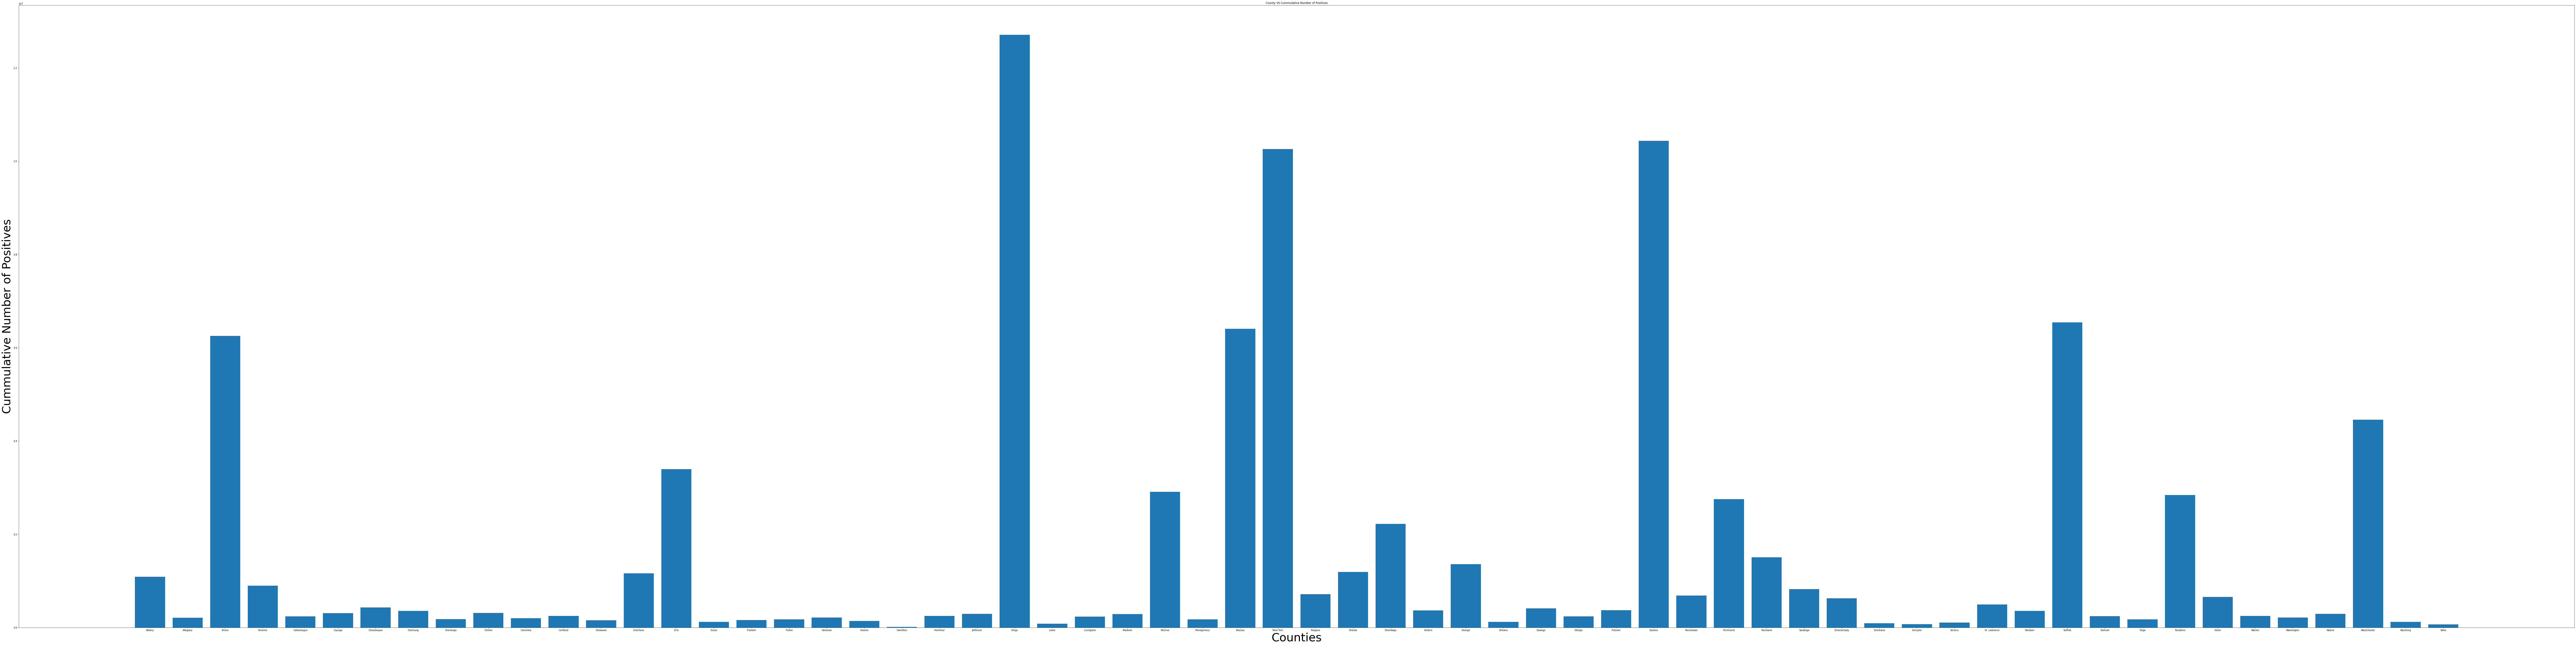

In [11]:
# Plotting the cummulative number of positives till now in each county

fetch_sql = 'SELECT county_id, sum(new_positives) FROM Covidcases group by county_id'
output = execute_sql_statement(fetch_sql, conn_norm)
output = pd.DataFrame(output)
output = output.rename(columns = {0:'county', 1:'Cummulative Number of Positives'})

def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
            return key
 
    return "key doesn't exist"

for i in range(0, len(output['county'])):
    output.county[i] = get_key(output.county[i], dict_county)

plt.figure(figsize=(200,50))
plt.title('County VS Cummulative Number of Positives')
plt.xlabel('Counties',fontsize='50')
plt.ylabel('Cummulative Number of Positives', fontsize='50')
plt.bar(output['county'],output['Cummulative Number of Positives'])
plt.show()

#conn_norm.commit()

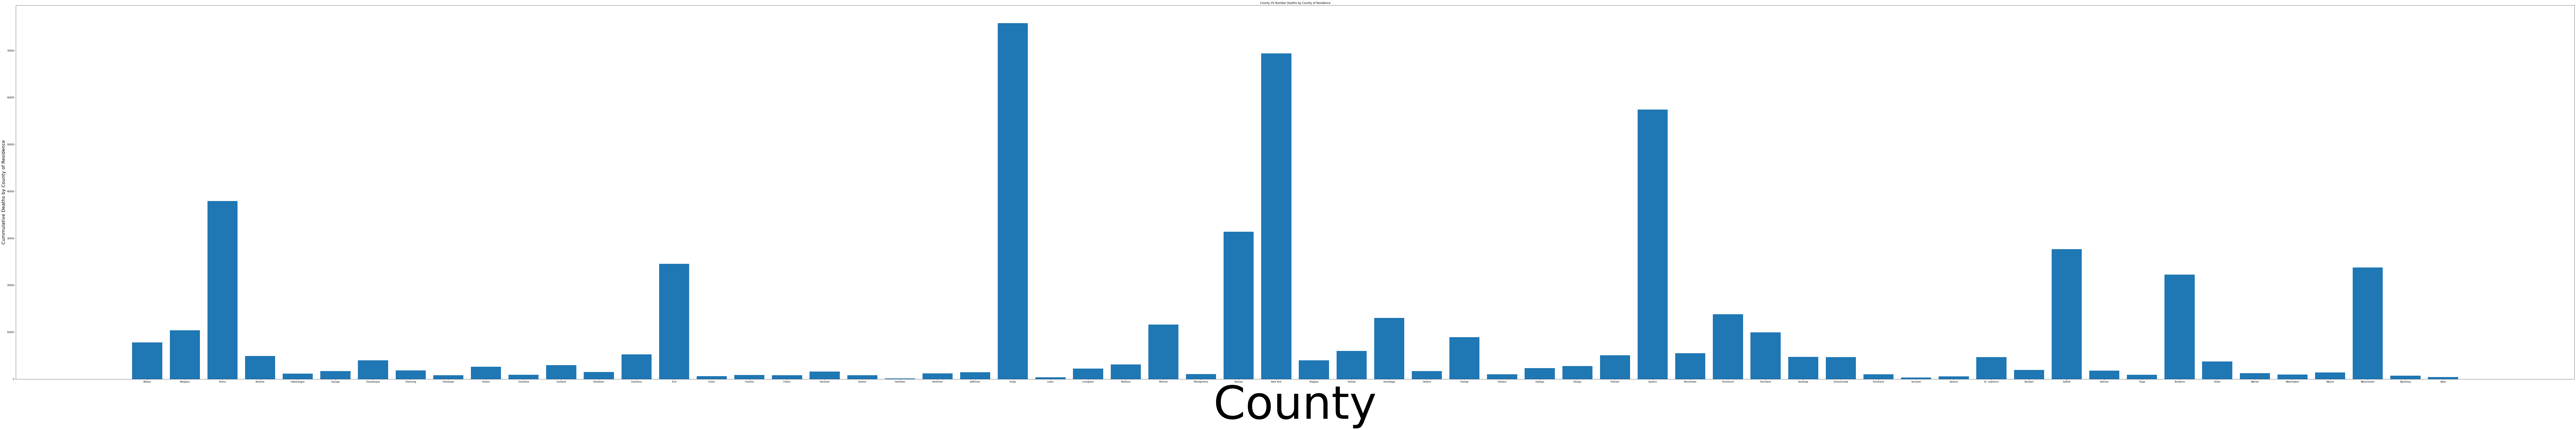

In [12]:
# Plotting the  deaths by county of residence so far

fetch_sql = 'SELECT county_id,deaths_in_county_residents FROM Fatalities '
output_new = execute_sql_statement(fetch_sql, conn_norm)
output_new = pd.DataFrame(output_new)
output_new = output_new.rename(columns = {0:'county', 1:'Number_of_deaths'})

def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
            return key
 
    return "key doesn't exist"

for i in range(0, len(output_new['county'])):
    output_new.county[i] = get_key(output_new.county[i], dict_county)
plt.figure(figsize=(200,30))
plt.title('County VS Number Deaths by County of Residence')
plt.xlabel('County',fontsize='200')
plt.ylabel('Cummulative Deaths by County of Residence', fontsize='20')
plt.bar(output_new['county'],output_new['Number_of_deaths'])
plt.show()  
conn_norm.commit()

According to the above findings, 'Kings' county has been the hardest hit thus far since the first case was discovered in New York.

### Analyzing the Data

Now let us analyze the current situation in the state.
<br>Take a look at the data from the last 30 days to see what's going on right now.

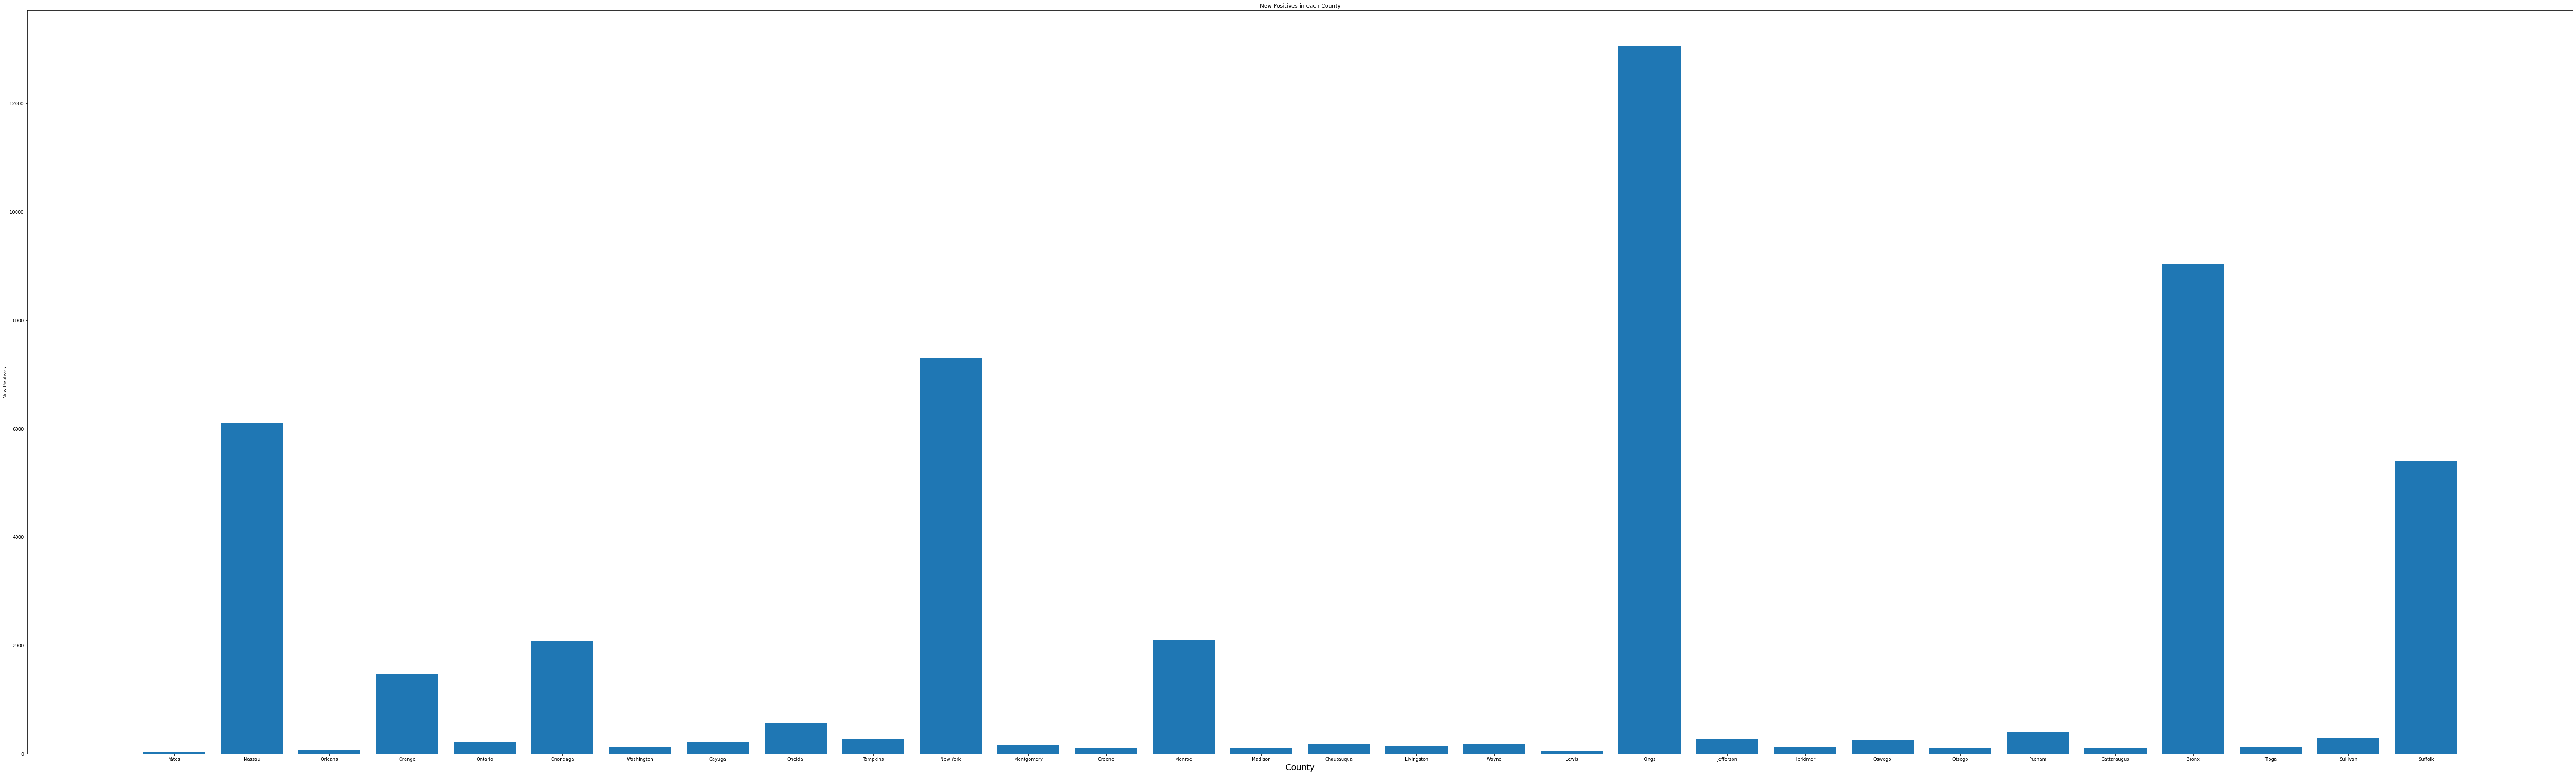

In [13]:
# Plotting the New Positive cases in each county over the last 30 days

df_test = df_test.iloc[:30:]
x3 = df_test['County']
y3= df_test['New Positives']
plt.figure(figsize=(100,30))
plt.title('New Positives in each County')
plt.xlabel('County',fontsize='18')
plt.ylabel('New Positives')
plt.bar(x3,y3)
plt.show()

Once again, it is clear that 'Kings' is still suffering the most. Now let us analyze the present trend in the Kings county.

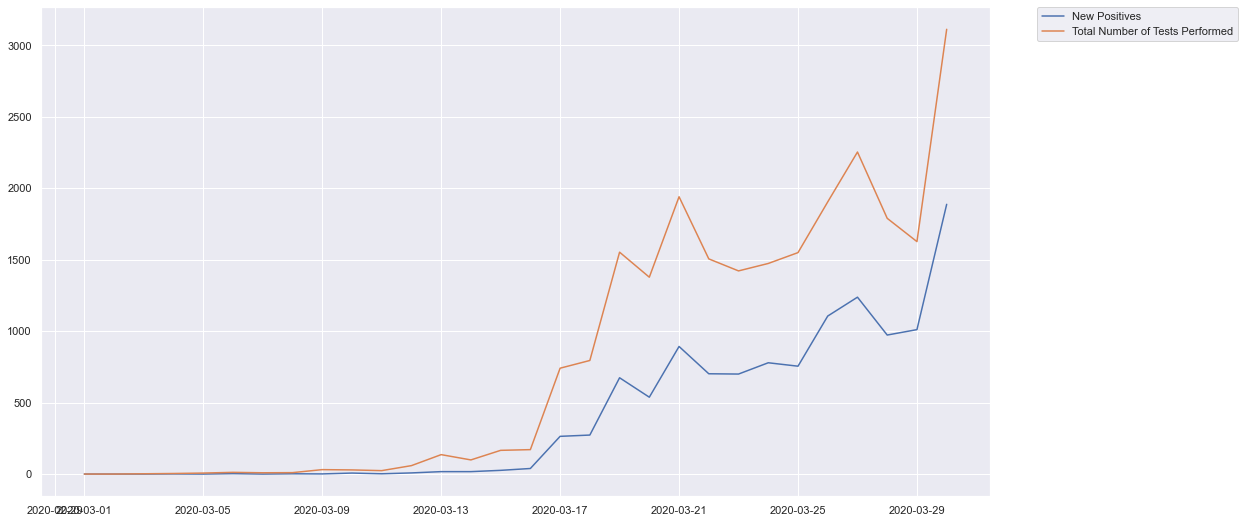

In [37]:
# Plotting New Positives and Total Number of Tests Performed from the past 30 days

Kings_df_test = df_test.loc[df_test['County'] == 'Kings']
Kings_df_test.head()
kings_present_test_data = Kings_df_test.iloc[:30:]
tests = kings_present_test_data['Total Number of Tests Performed']
positives = kings_present_test_data['New Positives']
plt.figure(figsize=(17,9))
plt.plot(kings_present_test_data['Test Date'], positives, label = 'New Positives')
plt.plot(kings_present_test_data['Test Date'], tests, label = 'Total Number of Tests Performed')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0)

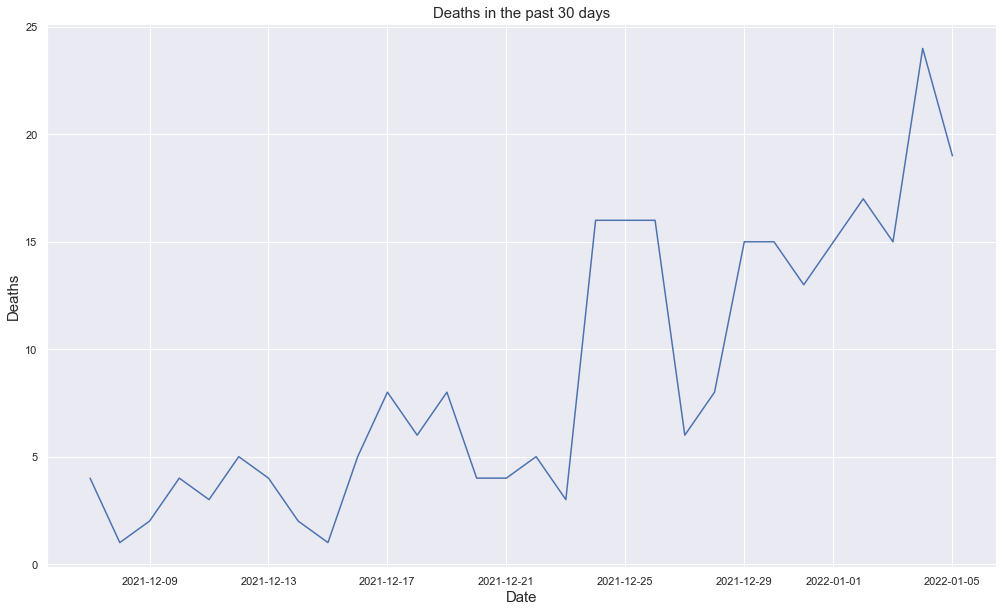

In [38]:
# Plotting fatalities in December for Kings

Kings_fatalities = df_fatalities.loc[df_fatalities['County'] == 'Kings']
kings_present_death_data = Kings_fatalities.iloc[:30:]
dates = kings_present_death_data['Report Date']
deaths= abs(kings_present_death_data['Deaths by County of Residence'].diff())
plt.figure(figsize=(17,10))
plt.title('Deaths in the past 30 days',fontsize='15')
plt.xlabel('Date',fontsize='15')
plt.ylabel('Deaths',fontsize='15')
plt.plot(dates, deaths)


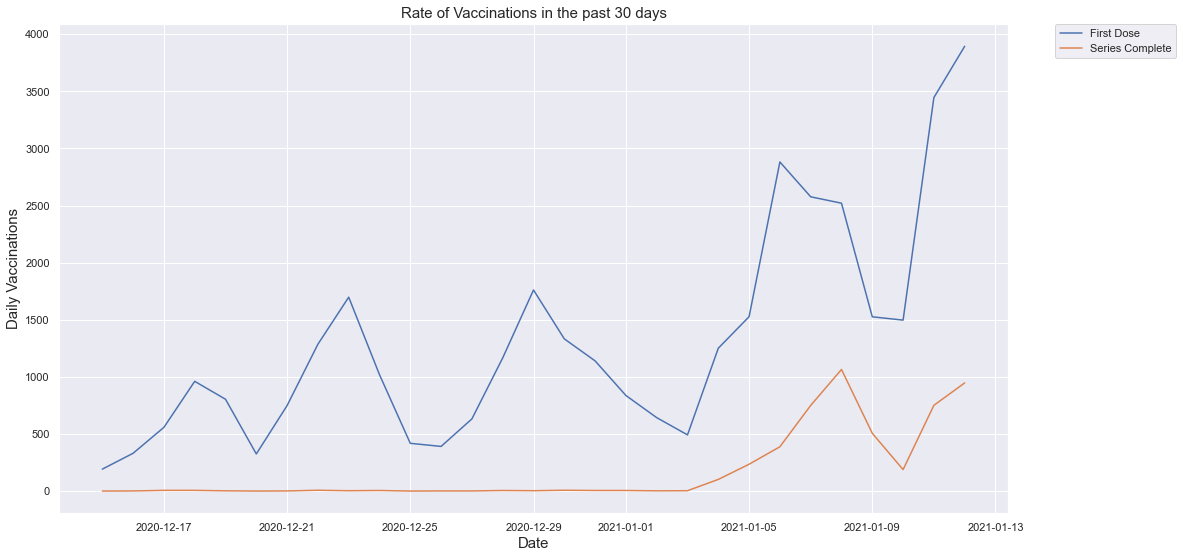

In [39]:
# Plotting the rate of vaccinations in December for Kings

Kings_vaccination = df_vaccination.loc[df_vaccination['County'] == 'Kings']
kings_present_vaccine_data = Kings_vaccination.iloc[:30:]
date = kings_present_vaccine_data['Report as of']
daily_vaccinations_dose1= abs(kings_present_vaccine_data['First Dose'].diff())
daily_vaccinations_dose2= abs(kings_present_vaccine_data['Series Complete'].diff())
plt.figure(figsize=(17,9))
plt.title('Rate of Vaccinations in the past 30 days',fontsize='15')
plt.xlabel('Date',fontsize='15')
plt.ylabel('Daily Vaccinations',fontsize='15')
plt.plot(date, daily_vaccinations_dose1, label ='First Dose')
plt.plot(date, daily_vaccinations_dose2, label ='Series Complete')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0)

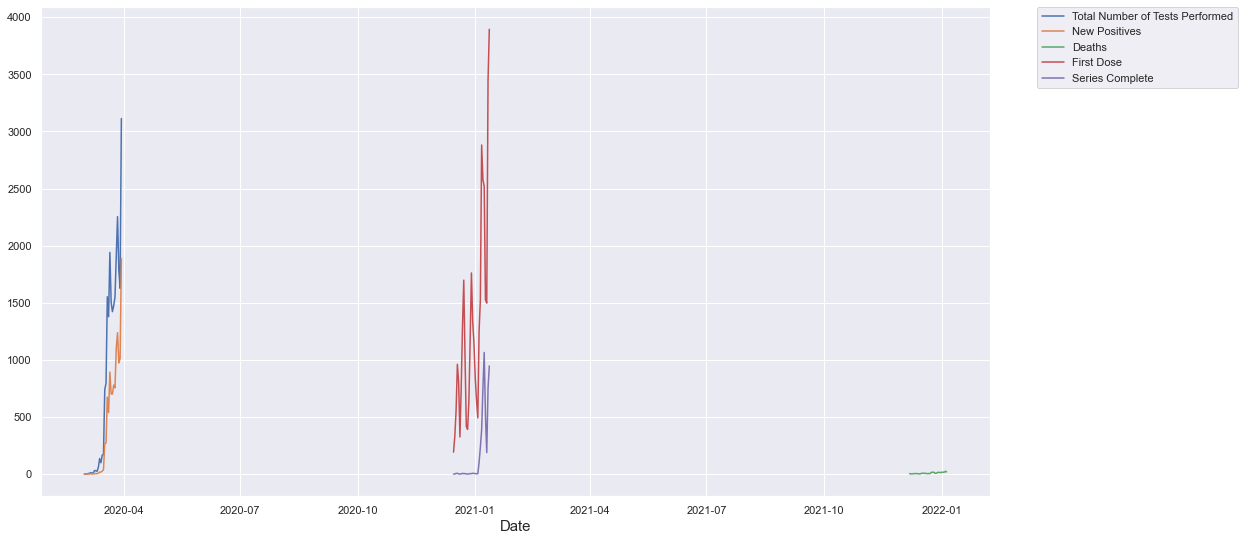

In [42]:
# Plotting all together for a better understanding

plt.figure(figsize=(17,9))
plt.xlabel('Date',fontsize='15')
plt.plot(kings_present_test_data['Test Date'], tests, label = 'Total Number of Tests Performed')
plt.plot(kings_present_test_data['Test Date'], positives, label = 'New Positives')
plt.plot(kings_present_death_data['Report Date'], deaths, label= 'Deaths')
plt.plot(date, daily_vaccinations_dose1, label ='First Dose')
plt.plot(date, daily_vaccinations_dose2, label ='Series Complete')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0)

According to the above findings, after December 13, the number of deaths increased along with the number of new positives, while the number of tests performed decreased along with the number of people who are getting vaccinated on a daily basis. 
If the current trend continues, Kings will be in a bad situation. So, using 'Time Series Analysis,' let us forecast the future trend on new positives using it's historical data.

### Time Series Analysis

In [43]:
# Scrapping only the data of Kings county from the whole testing data set

data_testing = "https://health.data.ny.gov/api/views/xdss-u53e/rows.csv"

df_test = pd.read_csv(data_testing)
df_test['Test Date'] = pd.to_datetime(df_test['Test Date'])
Kings_df_test = df_test.loc[df_test['County'] == 'Kings']
Kings_df_test.head()

,Test Date,County,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed
15571,2020-03-01,Kings,0,0,0,0
15572,2020-03-02,Kings,0,0,0,0
15573,2020-03-03,Kings,0,0,2,2
15574,2020-03-04,Kings,1,1,4,6
15575,2020-03-05,Kings,0,1,7,13


In [44]:
Kings_df_test.index = Kings_df_test['Test Date']
del Kings_df_test['Test Date']

In [45]:
# Computing the daily rate of new positives for Kings

rate = Kings_df_test["New Positives"]/ Kings_df_test["Total Number of Tests Performed"]
Kings_df_test['Rate'] = rate  # Adding the Rate column to the data
Kings_df_test.head()

,County,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed,Rate
Test Date,,,,,,
2020-03-01,Kings,0,0,0,0,NaN
2020-03-02,Kings,0,0,0,0,NaN
2020-03-03,Kings,0,0,2,2,0.00
2020-03-04,Kings,1,1,4,6,0.25
2020-03-05,Kings,0,1,7,13,0.00


In [46]:
# Calculating the rolling mean and standard deviation
rolling_mean_kings=Kings_df_test.rolling(7).mean()
rolling_std_kings = Kings_df_test.rolling(7).std()
rolling_mean_kings.head()

,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed,Rate
Test Date,,,,,
2020-03-01,NaN,NaN,NaN,NaN,NaN
2020-03-02,NaN,NaN,NaN,NaN,NaN
2020-03-03,NaN,NaN,NaN,NaN,NaN
2020-03-04,NaN,NaN,NaN,NaN,NaN
2020-03-05,NaN,NaN,NaN,NaN,NaN


In [47]:
rolling_std_kings.head()

,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed,Rate
Test Date,,,,,
2020-03-01,NaN,NaN,NaN,NaN,NaN
2020-03-02,NaN,NaN,NaN,NaN,NaN
2020-03-03,NaN,NaN,NaN,NaN,NaN
2020-03-04,NaN,NaN,NaN,NaN,NaN
2020-03-05,NaN,NaN,NaN,NaN,NaN


In [48]:
# Adding the Rolling_Mean and Rolling_Std columns to the data set

Kings_df_test['Rolling_Mean'] = rolling_mean_kings["New Positives"]
Kings_df_test['Rolling_Std'] = rolling_std_kings["New Positives"]
Kings_df_test.head()

,County,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed,Rate,Rolling_Mean,Rolling_Std
Test Date,,,,,,,,
2020-03-01,Kings,0,0,0,0,NaN,NaN,NaN
2020-03-02,Kings,0,0,0,0,NaN,NaN,NaN
2020-03-03,Kings,0,0,2,2,0.00,NaN,NaN
2020-03-04,Kings,1,1,4,6,0.25,NaN,NaN
2020-03-05,Kings,0,1,7,13,0.00,NaN,NaN


<AxesSubplot:xlabel='Test Date'>

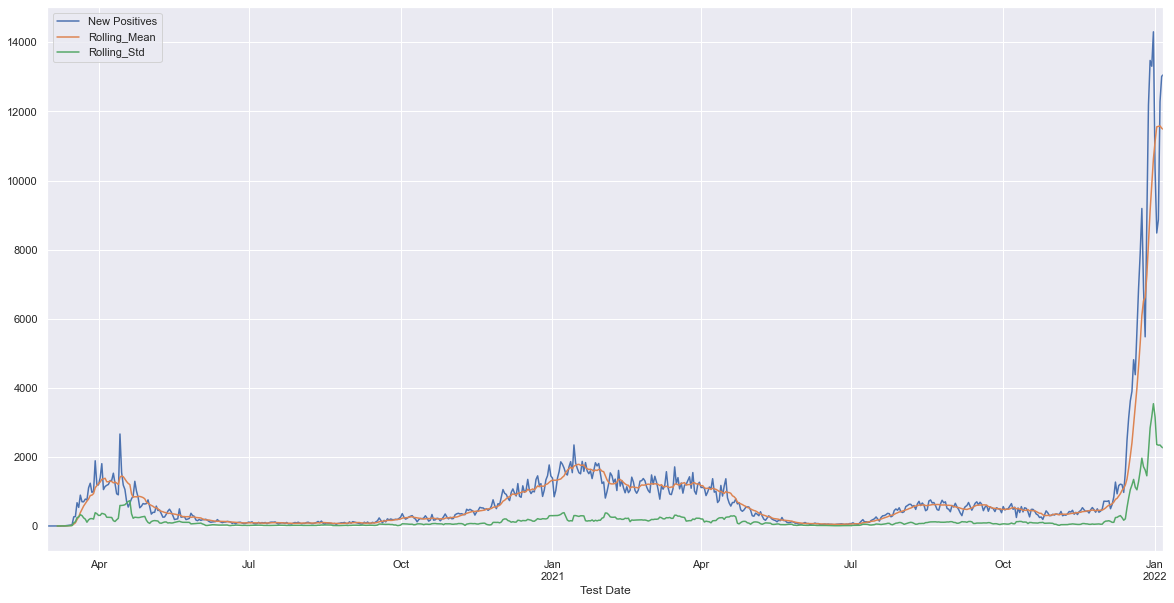

In [49]:
# Plot the original data, rolling mean, and roling standard deviation of New Positives
Kings_df_test[:].plot(  y= ["New Positives","Rolling_Mean","Rolling_Std"],figsize=(20,10))

In [50]:
# Selecting only New Positives and dropping the NA values

Kings_df = Kings_df_test[['New Positives']].copy()
Kings_df = Kings_df.dropna()
Kings_df.head()


,New Positives
Test Date,
2020-03-01,0
2020-03-02,0
2020-03-03,0
2020-03-04,1
2020-03-05,0


In [51]:
# Performing Augmented Dickey-Fuller Test to determine whether a time series is stationary or not.

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(Kings_df[:],autolag="AIC")

output_df = pd.DataFrame({"Values":[adf_test[0],adf_test[1],adf_test[2],adf_test[3], adf_test[4]['1%'], adf_test[4]['5%'], adf_test[4]['10%']]  ,
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})

print(output_df)

       Values                       Metric
0   -1.502641              Test Statistics
1    0.532204                      p-value
2   20.000000             No. of lags used
3  656.000000  Number of observations used
4   -3.440358          critical value (1%)
5   -2.865956          critical value (5%)
6   -2.569122         critical value (10%)


In [52]:
autocorrelation_lag3 = Kings_df['New Positives'].autocorr(lag=1)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = Kings_df['New Positives'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = Kings_df['New Positives'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.9743613623054962
Six Month Lag:  0.9138545911232618
Nine Month Lag:  0.864603759635431


In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns 

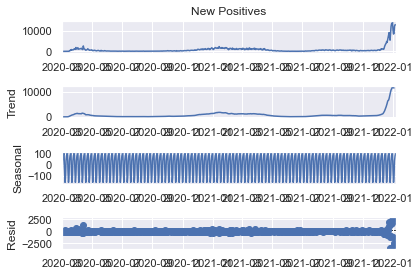

In [54]:
# Seasonal Plot of the Time Series

decompose = seasonal_decompose(Kings_df['New Positives'],model='additive', period=7)
decompose.plot()
plt.show()

            train
Test Date        
2021-10-27    438
2021-10-28    382
2021-10-29    300
2021-10-30    301
2021-10-31    339
            test
Test Date       
2021-11-01   316
2021-11-02   349
2021-11-03   340
2021-11-04   332
2021-11-05   421


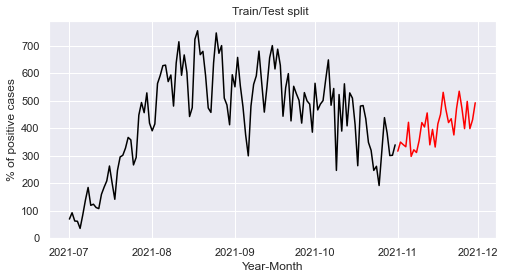

In [55]:
#Splitting the data into Test and Train sets for the analysis

Kings_df['Date'] = Kings_df.index
train = Kings_df[Kings_df['Date']< pd.to_datetime("2021-11-01", format='%Y-%m-%d')]
train = train[train['Date']>= pd.to_datetime("2021-07-01", format='%Y-%m-%d')]
train['train'] = train['New Positives']
del train['Date']
del train['New Positives']
print(train.tail())

test = Kings_df[Kings_df['Date']< pd.to_datetime("2021-12-01", format='%Y-%m-%d')]
test = test[test['Date']>= pd.to_datetime("2021-11-01", format='%Y-%m-%d')]
test['test'] = test['New Positives']
del test['Date']
del test['New Positives']
print(test.head())

# Plottting the test and train data
plt.figure(figsize=(8,4))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split ")
plt.ylabel("% of positive cases")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [56]:
# Let us create a data frame for the test that predicts the pattern including January, 2022.

Future_test_data = pd.DataFrame()
Future_test_data['Date'] = pd.date_range(start='11/1/2021', periods=len(range(1,80)), freq='D')
Future_test_data['Date'] = pd.to_datetime(Future_test_data['Date'])
Future_test_data.head()

,Date
0,2021-11-01
1,2021-11-02
2,2021-11-03
3,2021-11-04
4,2021-11-05


In [57]:
# Prediction of data

import sys
!{sys.executable} -m pip install pmdarima
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(Future_test_data))
forecast = pd.DataFrame(forecast,index = Future_test_data['Date'],columns=['Prediction'])
forecast


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1455.229, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1471.481, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1465.029, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1459.922, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1469.542, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1455.201, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1454.705, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1452.468, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1449.674, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1451.441, Time=0.35 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1447.448, Time=0.30 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1447.708, Time=0.26 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1448.462, Time=0.35 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1449.326, Time=0.34 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

,Prediction
Date,
2021-11-01,306.147508
2021-11-02,360.133146
2021-11-03,418.023278
2021-11-04,406.336350
2021-11-05,332.976400
...,...
2022-01-14,335.520332
2022-01-15,320.963872
2022-01-16,329.445184


<AxesSubplot:xlabel='Date'>

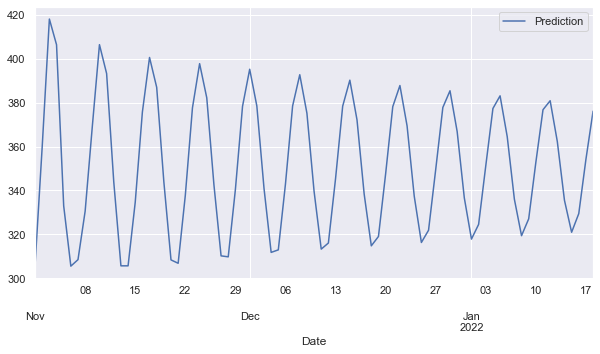

In [35]:
forecast[:].plot( y= ["Prediction"],figsize=(10,5)) # Plot the forecasted data

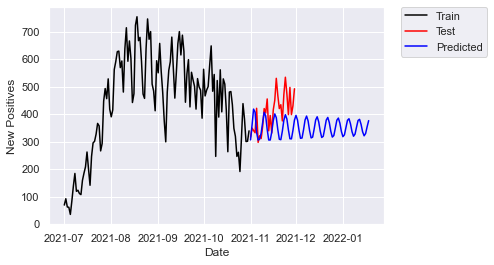

In [59]:
# Plotting the Test, Train, and Predicted data

plt.ylabel("New Positives")
plt.xlabel('Date')
plt.plot(train, color="black", label = "Train")
plt.plot(test, color="red", label = "Test")
plt.plot(forecast, color="blue", label = "Predicted")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0)